In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### Online and Offline Training data

In [2]:
df_on = pd.read_csv('DataSets/ccf_online_stage1_train.csv')
df_off = pd.read_csv('DataSets/ccf_offline_stage1_train.csv')

In [3]:
print("Online Training Data Sample\nShape:"+str(df_on.shape))
df_on.head()

Online Training Data Sample
Shape:(11429826, 7)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [4]:
print("Offline Training Data Sample\nShape:"+str(df_off.shape))
df_off.head()

Offline Training Data Sample
Shape:(1754884, 7)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


### Test Data(Offline)

In [5]:
df_test = pd.read_csv('DataSets/ccf_offline_stage1_test_revised.csv')
print("Testing Data(Offline) Sample\nShape:"+str(df_test.shape))
df_test.head()

Testing Data(Offline) Sample
Shape:(113640, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


#### Converting Date to DateTime format

In [6]:
#Online Training Data
df_on['Date'] = pd.to_datetime(df_on["Date"],format='%Y%m%d')
df_on['Date_received'] = pd.to_datetime(df_on["Date_received"],format='%Y%m%d')

#Offline Training Data
df_off['Date'] = pd.to_datetime(df_off["Date"],format='%Y%m%d')
df_off['Date_received'] = pd.to_datetime(df_off["Date_received"],format='%Y%m%d')

#Test Data
df_test['Date_received'] = pd.to_datetime(df_test["Date_received"],format='%Y%m%d')

### Removing Duplicates from Online and Offline Training Data

In [7]:
#Removing duplicates and giving frequency counts(Count) to each row

#Online
x = 'g8h.|$hTdo+jC9^@'    
df_on_unique = (df_on.fillna(x).groupby(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_on_unique["Date_received"]=pd.to_datetime(df_on_unique["Date_received"])
df_on_unique["Date"]=pd.to_datetime(df_on_unique["Date"])

print("Online Training Data Shape:"+str(df_on_unique.shape))

Online Training Data Shape:(5822543, 8)


In [8]:
#Offline
x = 'g8h.|$hTdo+jC9^@'   #garbage value for nan values 
df_off_unique = (df_off.fillna(x).groupby(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_off_unique["Date_received"]=pd.to_datetime(df_off_unique["Date_received"])
df_off_unique["Date"]=pd.to_datetime(df_off_unique["Date"])

print("Offline Training Data Shape:"+str(df_off_unique.shape))

Offline Training Data Shape:(1716991, 8)


#### Filling Nan for Distance (OFFLINE)

In [9]:
df_off_unique['Distance'].fillna(df_off_unique['Distance'].mean(), inplace=True)
df_off_unique['Distance'] = df_off_unique.Distance.astype(int)

### Converting Discount Ratio to Rate

In [10]:
#Funtion to convert discount ratio to discount rate
def convert_discount(discount):
    values = []
    for i in discount:
        if ':' in i:
            i = i.split(':')
            rate = round((int(i[0]) - int(i[1]))/int(i[0]),3)
            values.append([int(i[0]),int(i[1]),rate])
        elif '.' in i:
            i = float(i)
            x = 100*i
            values.append([100,int(100-x),i])
            
    discounts = dict(zip(discount,values))      
    return discounts
    

# convert_discount(list(df_of['Discount_rate']))

In [11]:
#ONLINE DATA
df_on_coupon = df_on_unique[(df_on_unique['Coupon_id'].isna()==False) & (df_on_unique['Coupon_id']!='fixed')]
discounts_online = list(df_on_coupon['Discount_rate'].unique())
df_on_coupon.loc[:,('Discount')] = df_on_coupon.loc[:,('Discount_rate')] 
df_on_coupon.loc[:,('Discount_rate')] = df_on_coupon.loc[:,('Discount')].map(convert_discount(discounts_online))
df_on_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_on_coupon.Discount_rate.values.tolist(), index= df_on_coupon.index)
df_on_coupon.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,25104,2,100145044,"[100, 10, 0.9]",2016-03-31,NaT,1,100:10,100,10,0.900
14,209,27710,1,100081876,"[150, 10, 0.933]",2016-05-14,2016-05-14,1,150:10,150,10,0.933
44,236,53305,2,100075632,"[200, 10, 0.95]",2016-02-21,NaT,1,200:10,200,10,0.950
45,236,53305,2,100181719,"[50, 1, 0.98]",2016-02-21,NaT,1,50:1,50,1,0.980
46,236,53305,2,100214552,"[150, 5, 0.967]",2016-02-21,NaT,1,150:5,150,5,0.967


In [12]:
#OFFLINE DATA
df_off_coupon = df_off_unique[(df_off_unique['Coupon_id'].isna()==False)].copy()
discounts_offline = list(df_off_coupon['Discount_rate'].unique())
df_off_coupon.loc[:,('Discount')] = df_off_coupon.loc[:,('Discount_rate')] 
df_off_coupon['Discount_rate'] = df_off_coupon['Discount'].map(convert_discount(discounts_offline))
df_off_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_off_coupon.Discount_rate.values.tolist(), index= df_off_coupon.index)
df_off_coupon.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,1433,8735.0,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,5,0.833
1,4,1469,2902.0,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,5,0.950
2,35,3381,1807.0,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,30,0.900
3,35,3381,9776.0,"[10, 5, 0.5]",0,2016-01-29,NaT,1,10:5,10,5,0.500
4,35,3381,11951.0,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,20,0.900


### Training Data (Online + Offline)

In [13]:
df_train = df_on_unique.append(df_off_unique, sort=False)
df_train = df_train.sort_values(by = ['User_id'] )
df_train = df_train.reset_index()
del df_train['index']
print("Training Data(Offline+Online) \nShape:"+str(df_train.shape))
df_train.head()

Training Data(Offline+Online) 
Shape:(7539534, 9)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0
2,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
4,35,3381,NaN,9776,10:5,2016-01-29,NaT,1,0.0


In [14]:
df_train_coupon = df_on_coupon.append(df_off_coupon, sort=False)

## DISCOUNT ANALYSIS

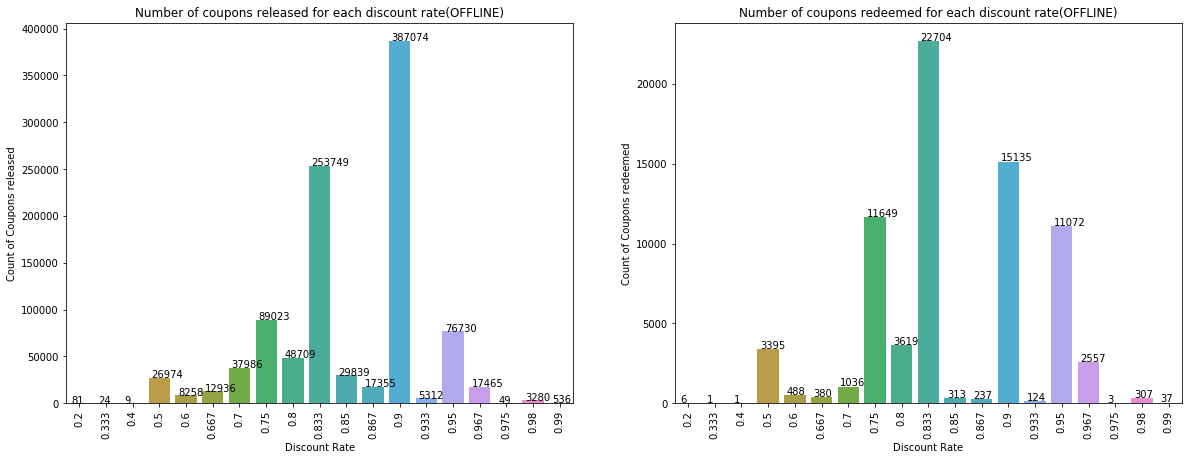

In [15]:
# Coupons Released and redeemed and Discount Rate(OFFLINE)
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,7))
plt.subplot(121)
ax1 = sns.countplot(df_off_coupon['Rate'])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
for p in ax1.patches:
        ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.xlabel('Discount Rate')
plt.ylabel('Count of Coupons released')
plt.title('Number of coupons released for each discount rate(OFFLINE)')

plt.subplot(122)
df_off_redeem_coupon= df_off_coupon[df_off_coupon['Date'].isna()==False]

ax2 = sns.countplot(df_off_redeem_coupon['Rate'])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
for p in ax2.patches:
        ax2.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
        
plt.xlabel('Discount Rate')
plt.ylabel('Count of Coupons redeemed')
plt.title('Number of coupons redeemed for each discount rate(OFFLINE)')

plt.show()

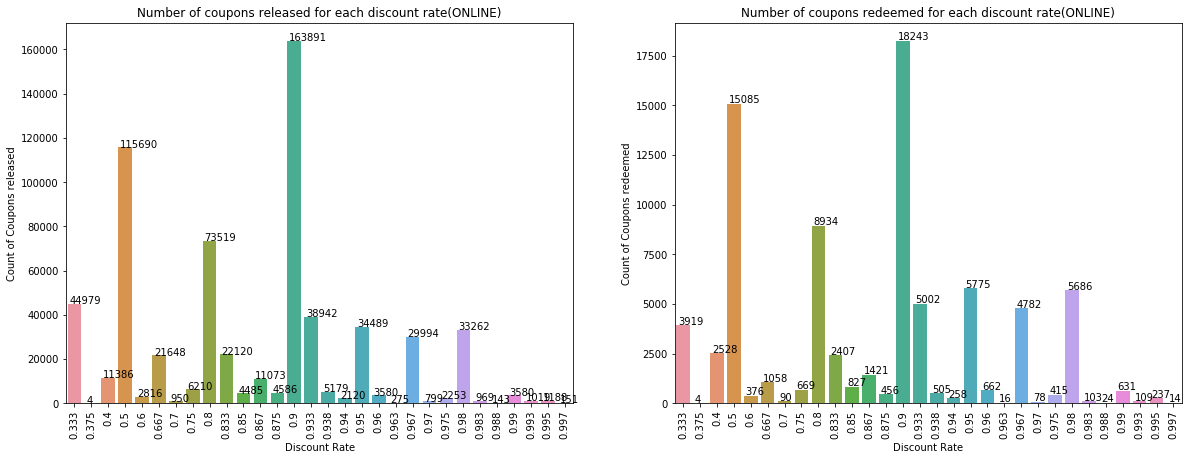

In [16]:
# Coupons Released and redeemed and Discount Rate(ONLINE)
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,7))
plt.subplot(121)
ax1 = sns.countplot(df_on_coupon['Rate'])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
for p in ax1.patches:
        ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.xlabel('Discount Rate')
plt.ylabel('Count of Coupons released')
plt.title('Number of coupons released for each discount rate(ONLINE)')

plt.subplot(122)
df_on_redeem_coupon= df_on_coupon[df_on_coupon['Date'].isna()==False]

ax2 = sns.countplot(df_on_redeem_coupon['Rate'])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
for p in ax2.patches:
        ax2.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
        
plt.xlabel('Discount Rate')
plt.ylabel('Count of Coupons redeemed')
plt.title('Number of coupons redeemed for each discount rate(ONLINE)')

plt.show()

In [17]:
discount_redemption =  pd.DataFrame(df_train_coupon.groupby(['Rate'])['Coupon_id','Date'].count()).reset_index()
discount_redemption.columns = ['Rate','Rate_Releases','Rate_Redeemed']
discount_redemption['Rate_Ratio'] = discount_redemption['Rate_Redeemed']/discount_redemption['Rate_Releases']
discount_redemption

,Rate,Rate_Releases,Rate_Redeemed,Rate_Ratio
0,0.200,81,6,0.074074
1,0.333,45003,3920,0.087105
2,0.375,4,4,1.000000
3,0.400,11395,2529,0.221939
4,0.500,142664,18480,0.129535
5,0.600,11074,864,0.078021
6,0.667,34584,1438,0.041580
7,0.700,38936,1126,0.028919
8,0.750,95233,12318,0.129346
9,0.800,122228,12553,0.102702


In [18]:
discount_redemption.to_csv('DataSets/DatasetsCreated/rate_level.csv',index=False)

## Date Analysis

#### Count of coupons released each day (OFFLINE)

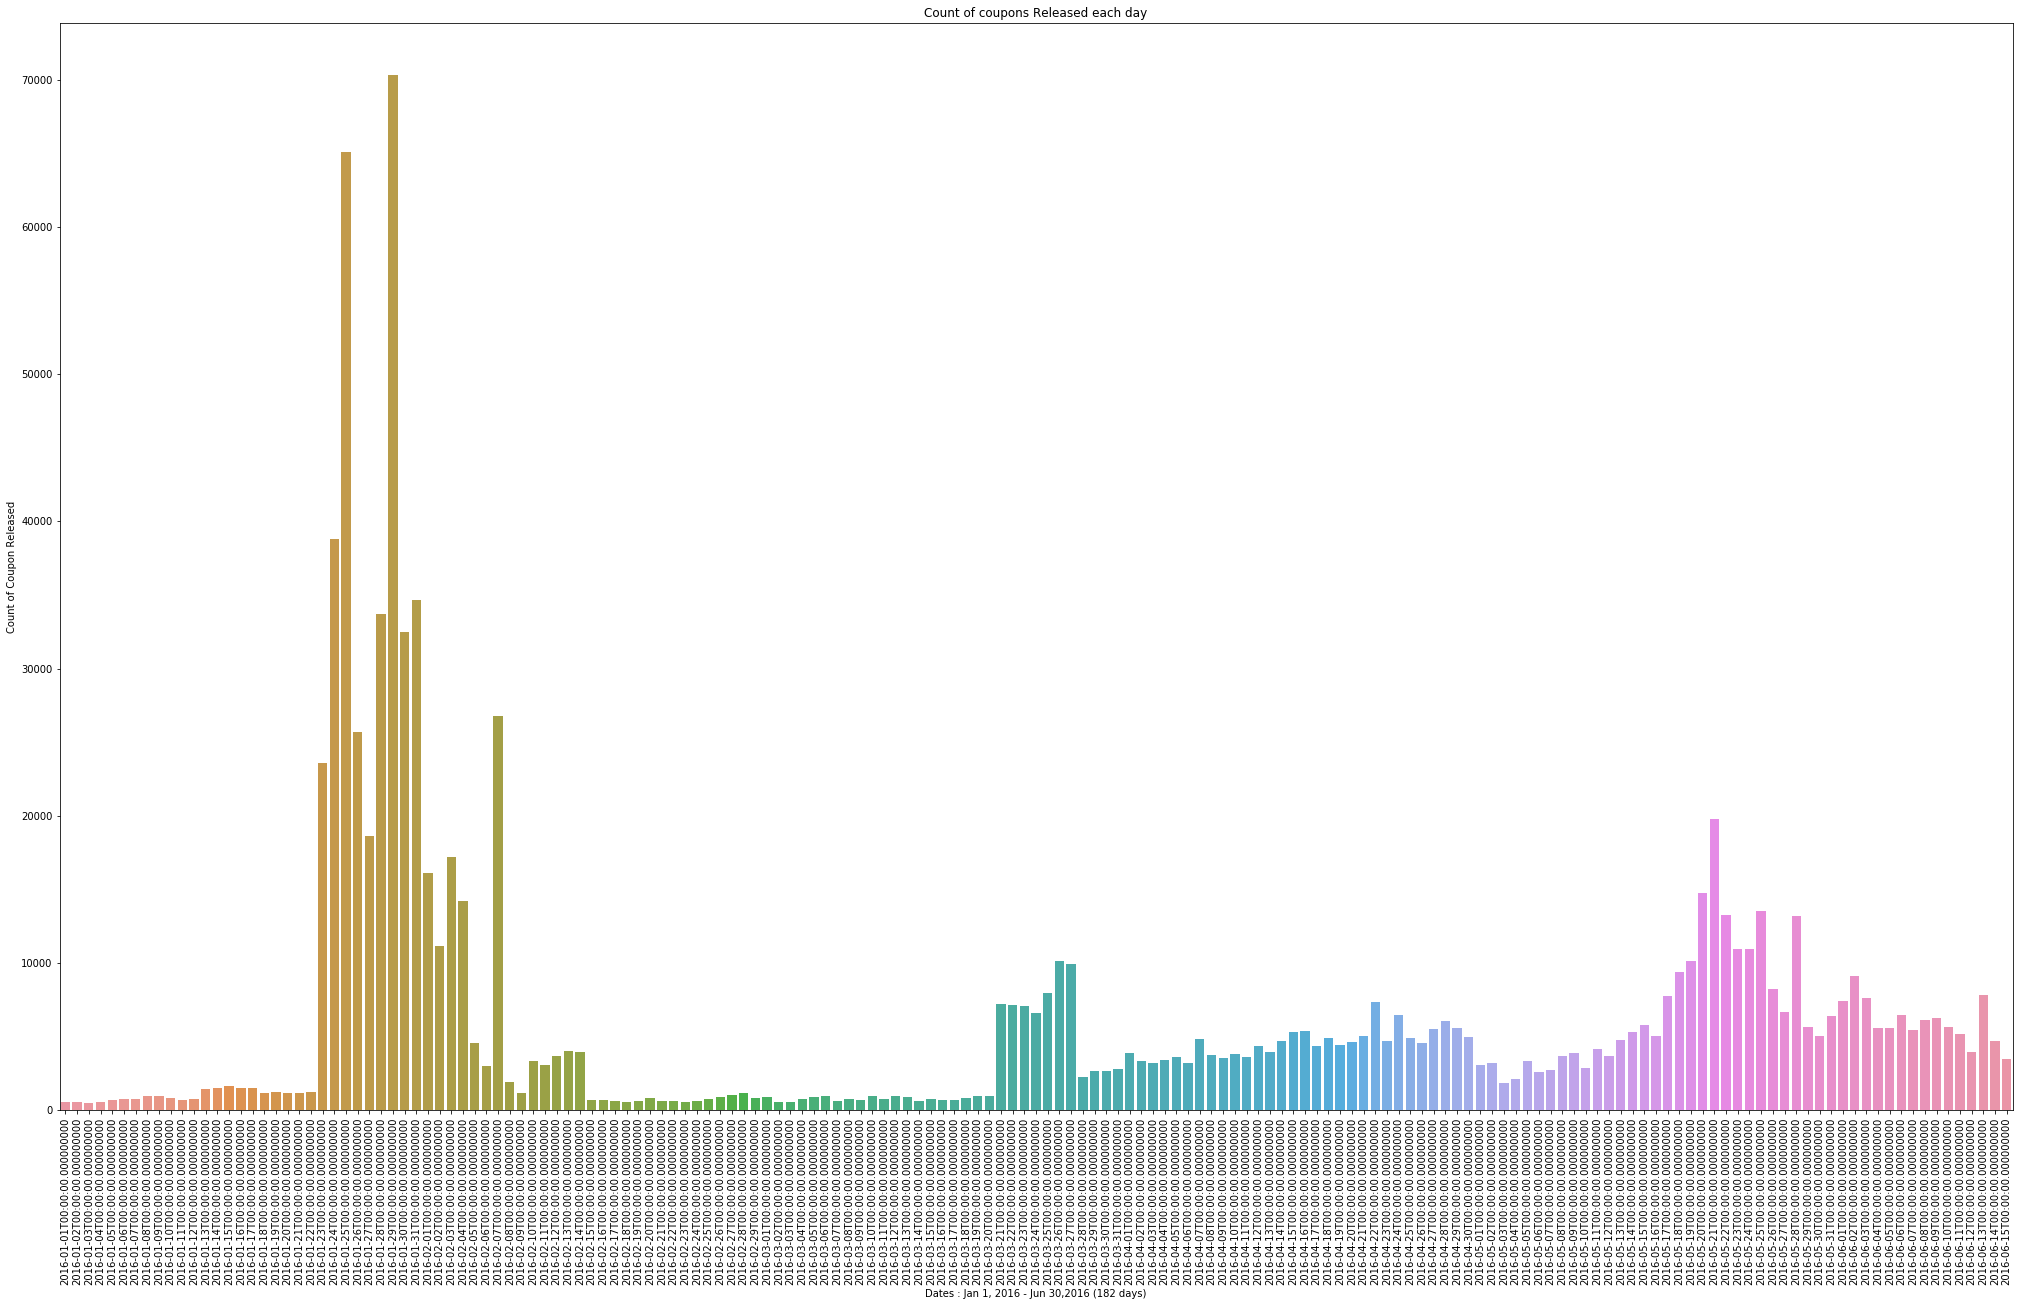

In [19]:
plt.figure(figsize=(35,20))
ax = sns.countplot(df_off_coupon['Date_received'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.xlabel('Dates : Jan 1, 2016 - Jun 30,2016 (182 days)')
plt.ylabel('Count of Coupon Released')
plt.title('Count of coupons Released each day')
plt.show()

#### Count of coupons redeemed each day (OFFLINE)

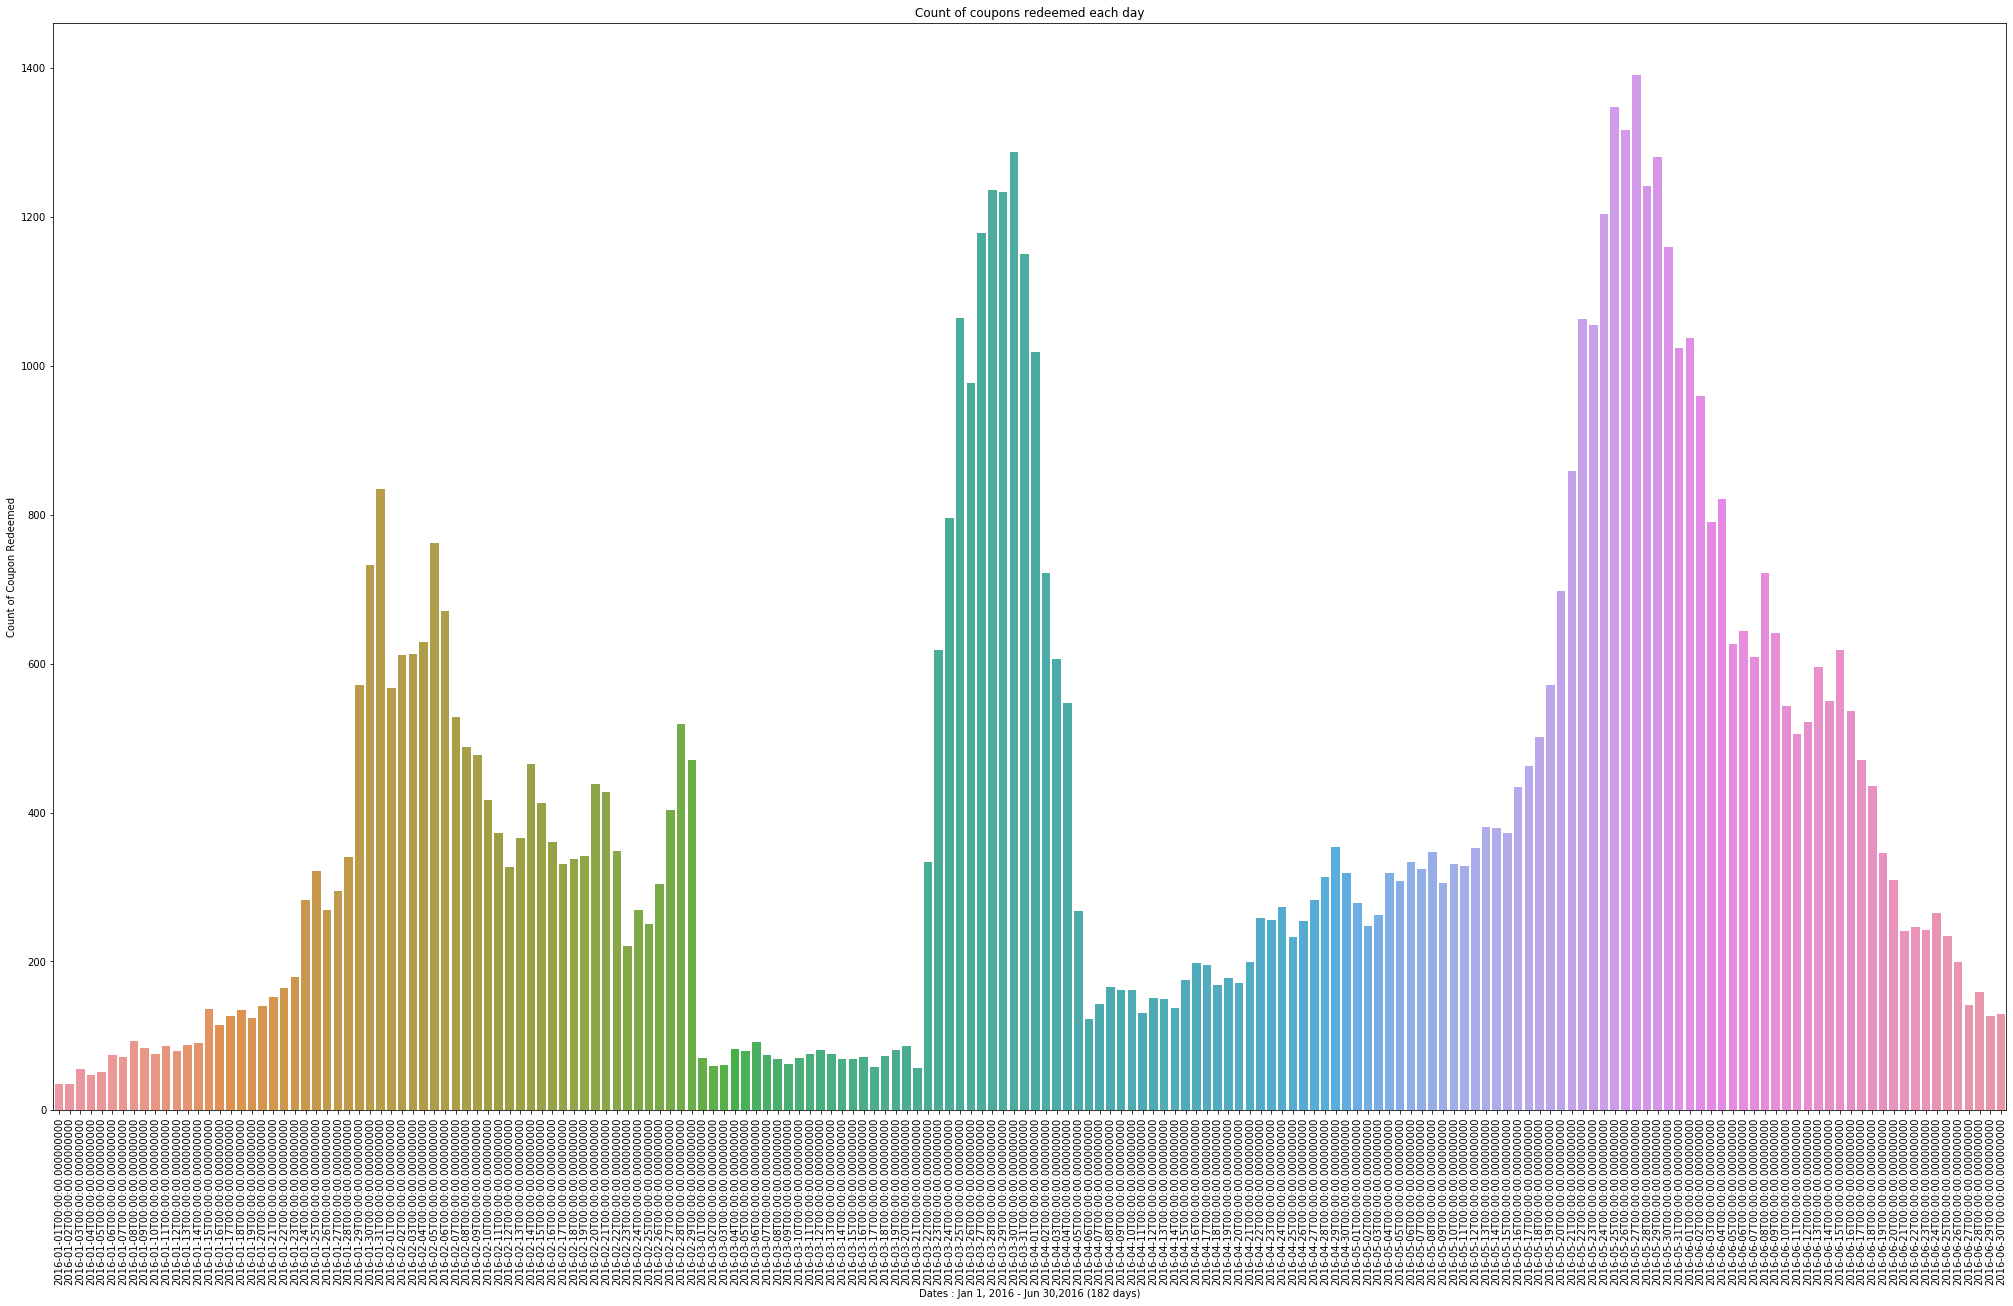

In [20]:
plt.figure(figsize=(35,20))
ax = sns.countplot(df_off_redeem_coupon['Date'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.xlabel('Dates : Jan 1, 2016 - Jun 30,2016 (182 days)')
plt.ylabel('Count of Coupon Redeemed')
plt.title('Count of coupons redeemed each day')
plt.show()

#### Count of coupons released each day (ONLINE)

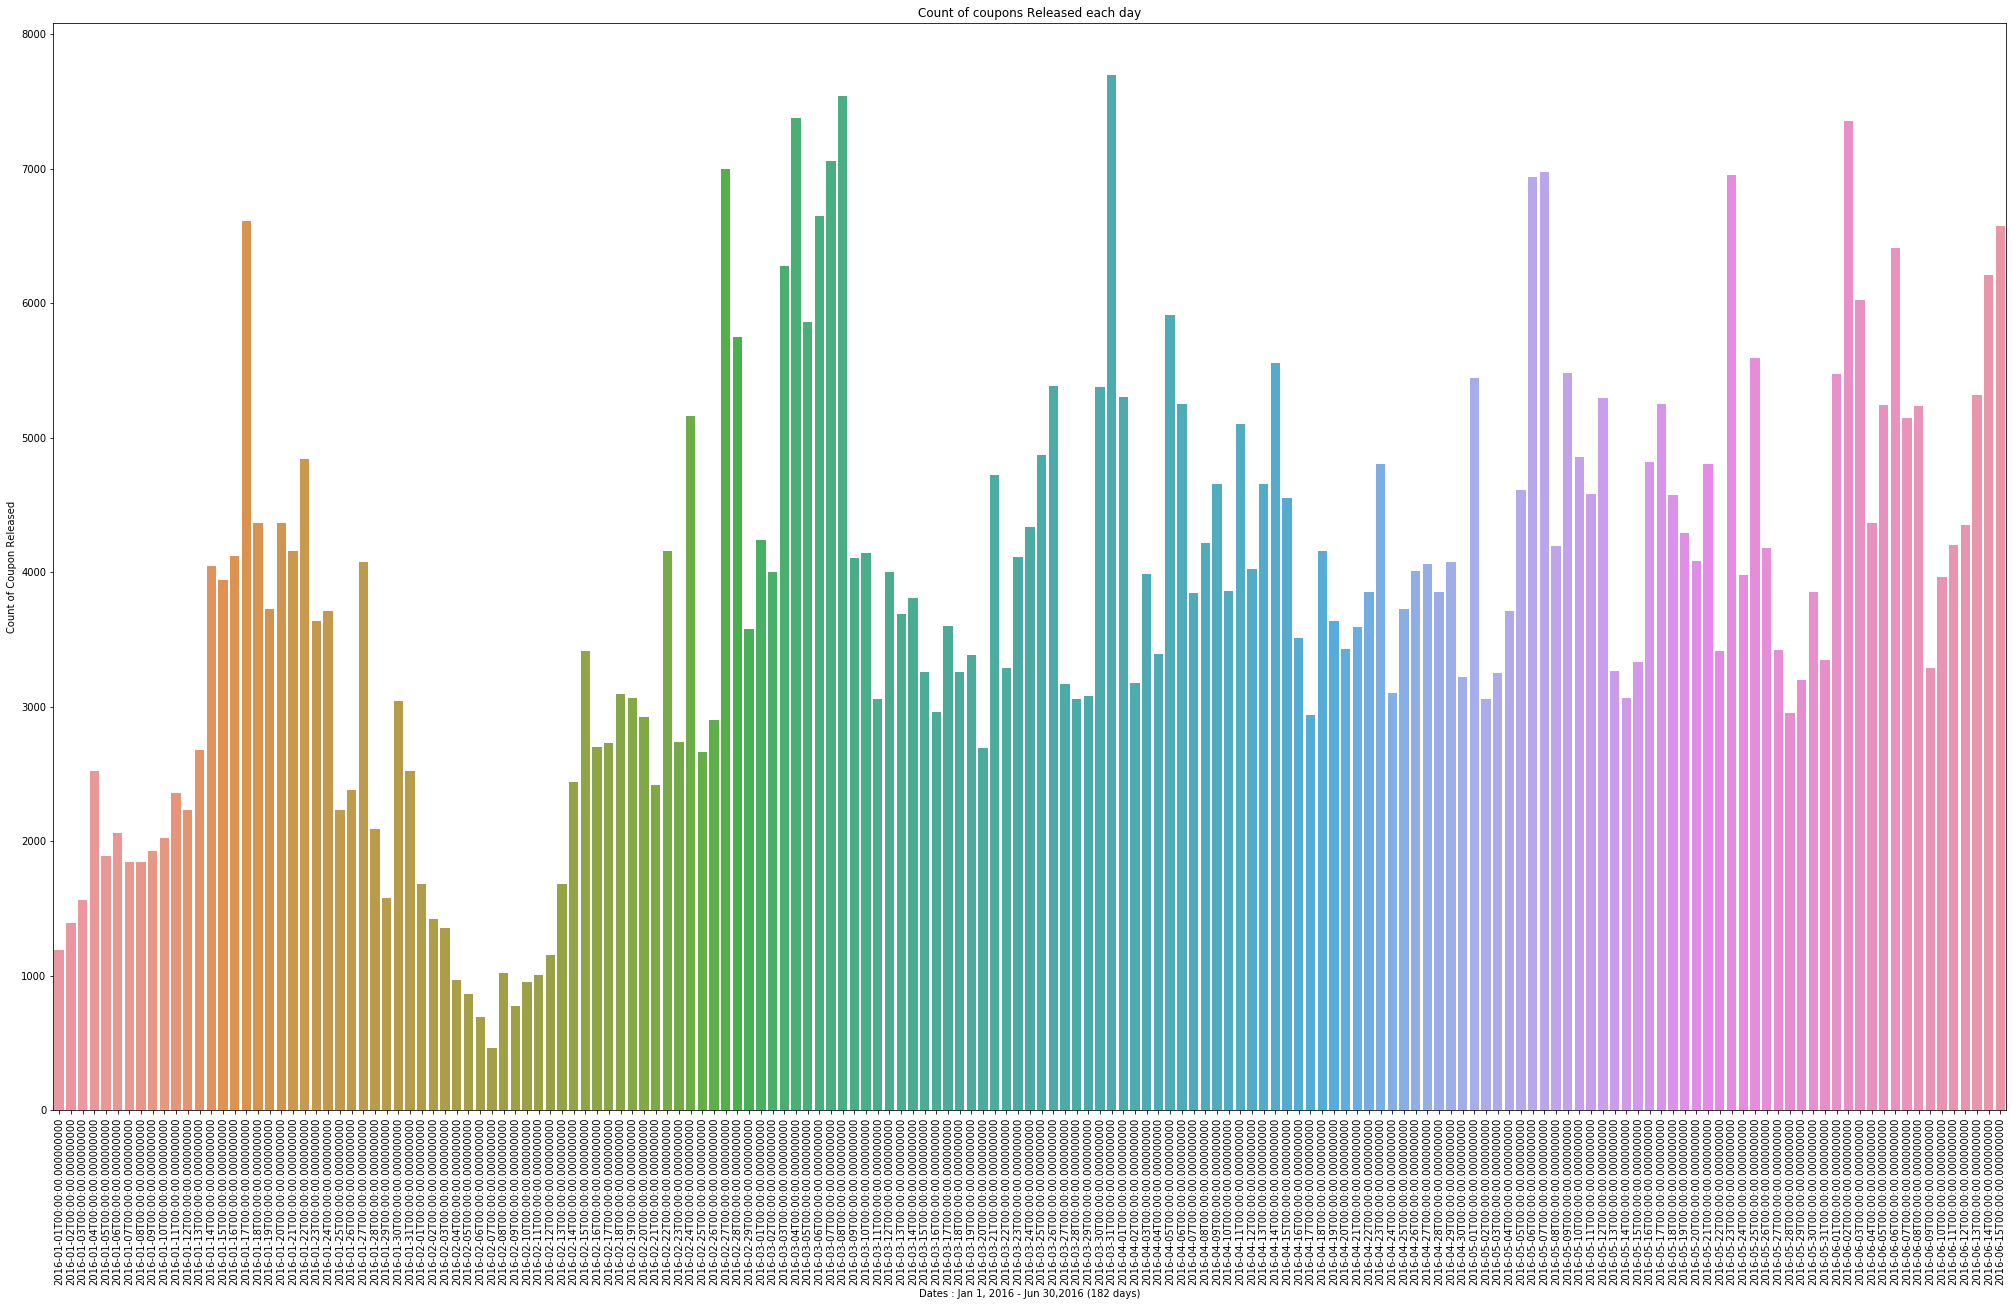

In [21]:
plt.figure(figsize=(35,20))
ax = sns.countplot(df_on_coupon['Date_received'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.xlabel('Dates : Jan 1, 2016 - Jun 30,2016 (182 days)')
plt.ylabel('Count of Coupon Released')
plt.title('Count of coupons Released each day')
plt.show()

#### Count of coupons redeemed each day (ONLINE)

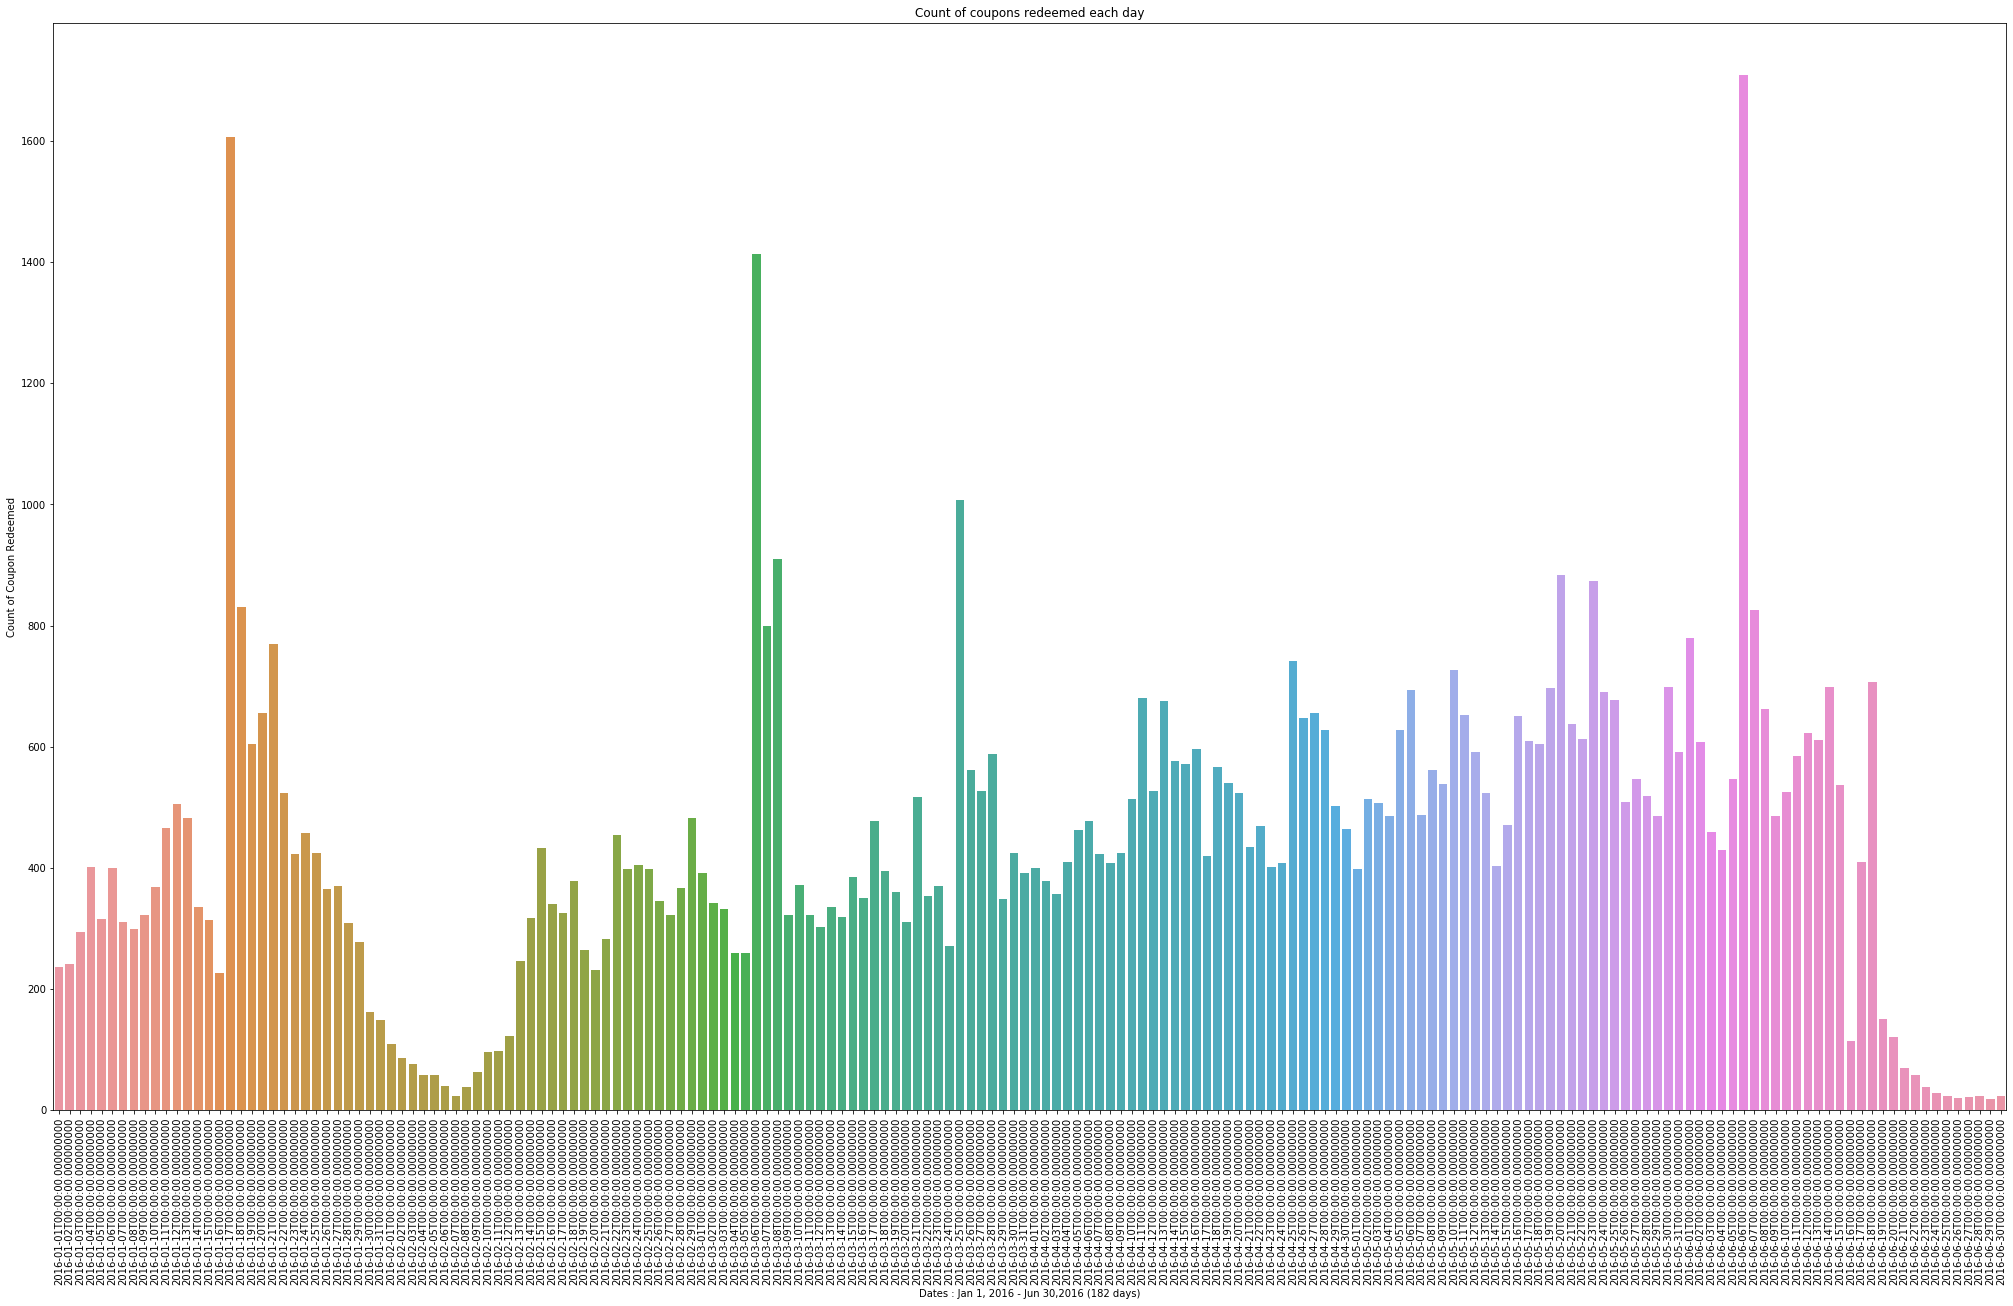

In [22]:
plt.figure(figsize=(35,20))
ax = sns.countplot(df_on_redeem_coupon['Date'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.xlabel('Dates : Jan 1, 2016 - Jun 30,2016 (182 days)')
plt.ylabel('Count of Coupon Redeemed')
plt.title('Count of coupons redeemed each day')
plt.show()

### Weekdays or Weekends for Date Received (Offline)

In [23]:
#Receive Date
df_off_coupon.loc[:,('Weekend')]  = np.where((df_off_coupon.loc[:,('Date_received')] .dt.dayofweek) < 5,0,1)
df_off_coupon.loc[:,('DayOfWeek')] = df_off_coupon.loc[:,('Date_received')].dt.dayofweek
df_off_coupon.loc[:,('Month')]  = (df_off_coupon.loc[:,('Date_received')]).dt.month

#Purchase Date
df_off_redeem_coupon.loc[:,('Weekend_p')]  = np.where((df_off_redeem_coupon.loc[:,('Date')] .dt.dayofweek) < 5,0,1)
df_off_redeem_coupon.loc[:,('DayOfWeek_p')] = df_off_redeem_coupon.loc[:,('Date')].dt.dayofweek
df_off_redeem_coupon.loc[:,('Month_p')]  = (df_off_redeem_coupon.loc[:,('Date')]).dt.month

df_off_redeem_coupon.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate,Weekend_p,DayOfWeek_p,Month_p
33,184,3381,9776.0,"[10, 5, 0.5]",0,2016-01-29,2016-02-28,1,10:5,10,5,0.500,1,6,2
76,417,775,5435.0,"[30, 5, 0.833]",0,2016-03-29,2016-04-12,1,30:5,30,5,0.833,0,1,4
150,687,6454,14031.0,"[100, 10, 0.9]",2,2016-01-28,2016-01-30,1,100:10,100,10,0.900,1,5,1
153,687,8594,9353.0,"[30, 1, 0.967]",2,2016-03-28,2016-04-02,1,30:1,30,1,0.967,1,5,4
158,696,4195,3726.0,"[100, 10, 0.9]",0,2016-04-11,2016-04-13,1,0.9,100,10,0.900,0,2,4


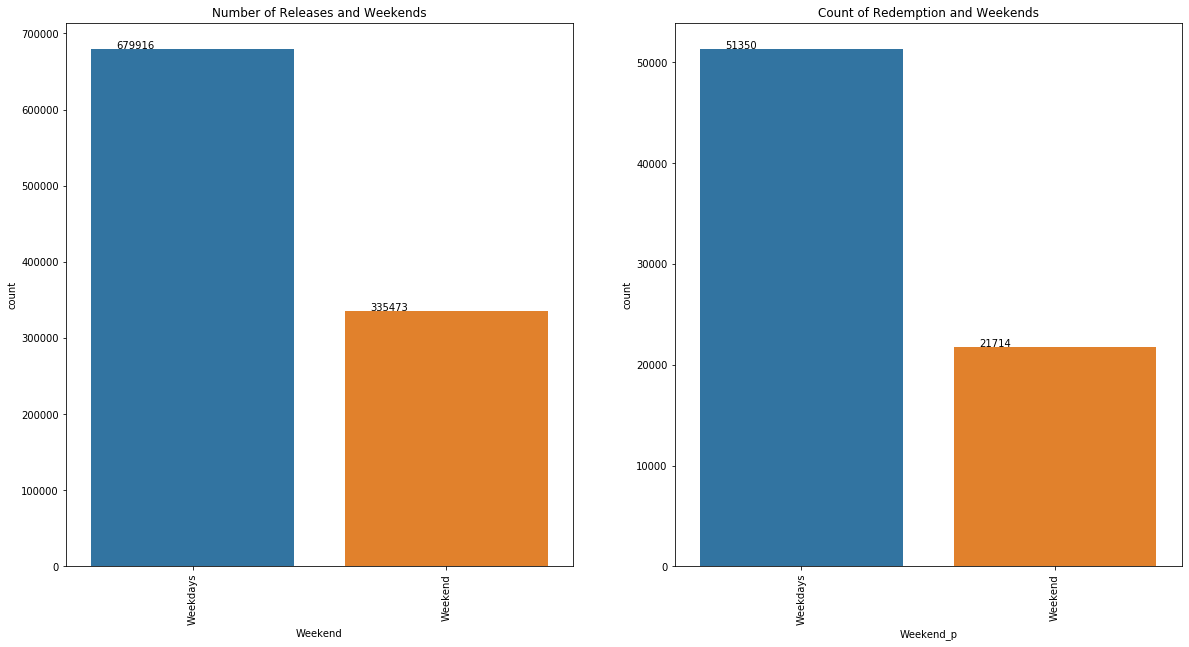

In [24]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
plt.subplot(121)
# plt.figure(figsize=(7,4))
ax1 = sns.countplot(df_off_coupon['Weekend'])
ax1.set_xticklabels(['Weekdays','Weekend'],rotation=90)
for p in ax1.patches:
        ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.title('Number of Releases and Weekends')

plt.subplot(122)
# plt.figure(figsize=(7,4))
ax2 = sns.countplot(df_off_redeem_coupon['Weekend_p'])
ax2.set_xticklabels(['Weekdays','Weekend'],rotation=90)
for p in ax2.patches:
        ax2.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.title('Count of Redemption and Weekends')

plt.show()

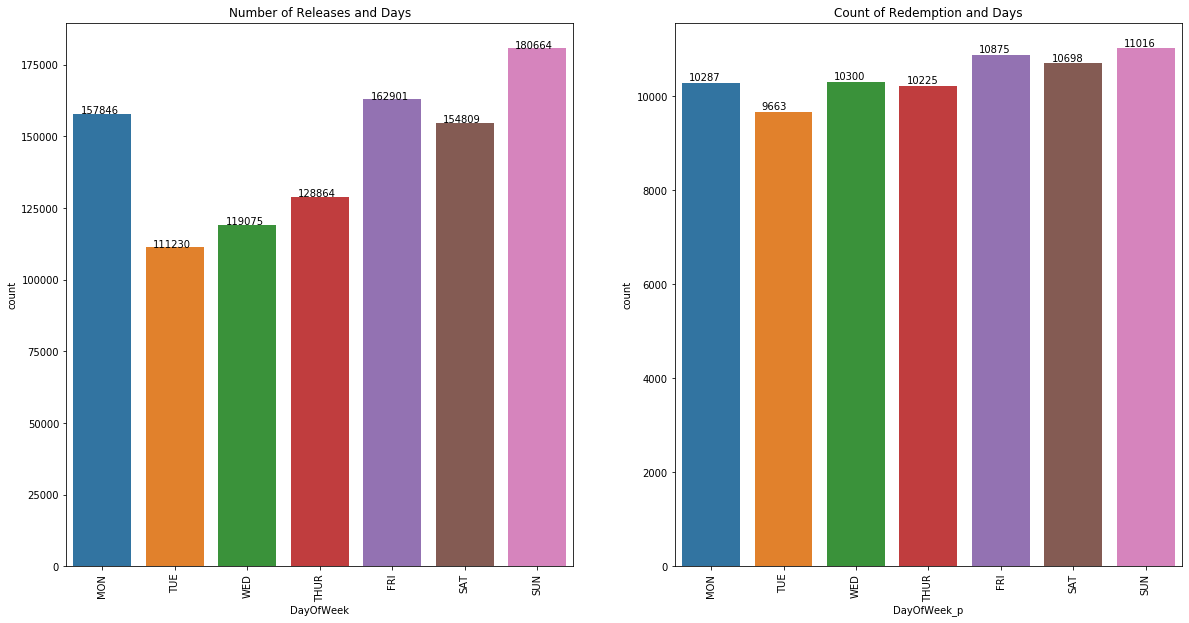

In [25]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
plt.subplot(121)
# plt.figure(figsize=(7,4))
ax1 = sns.countplot(df_off_coupon['DayOfWeek'])
ax1.set_xticklabels(['MON','TUE','WED','THUR','FRI','SAT','SUN'],rotation=90)
for p in ax1.patches:
        ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.title('Number of Releases and Days')

plt.subplot(122)
# plt.figure(figsize=(7,4))
ax2 = sns.countplot(df_off_redeem_coupon['DayOfWeek_p'])
ax2.set_xticklabels(['MON','TUE','WED','THUR','FRI','SAT','SUN'],rotation=90)
for p in ax2.patches:
        ax2.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.title('Count of Redemption and Days')

plt.show()

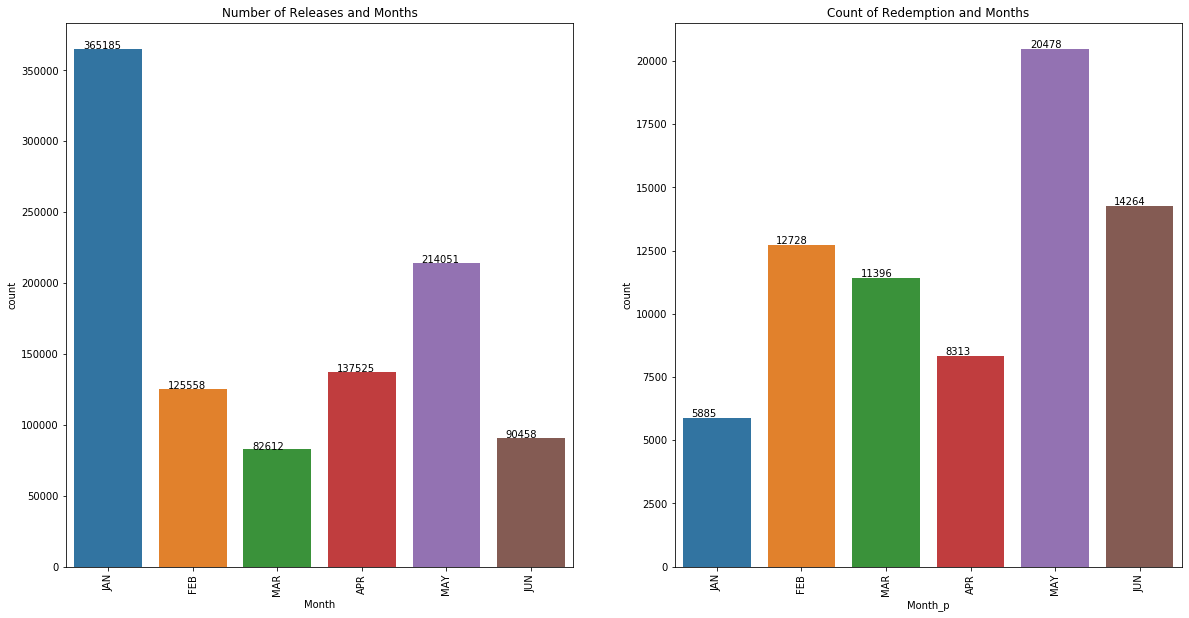

In [26]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
plt.subplot(121)
# plt.figure(figsize=(7,4))
ax1 = sns.countplot(df_off_coupon['Month'])
ax1.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN'],rotation=90)
for p in ax1.patches:
        ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.title('Number of Releases and Months')

plt.subplot(122)
# plt.figure(figsize=(7,4))
ax2 = sns.countplot(df_off_redeem_coupon['Month_p'])
ax2.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN'],rotation=90)
for p in ax2.patches:
        ax2.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.title('Count of Redemption and Months')

plt.show()

### MONTHLY PURCHASES WITH COUPON 

In [27]:
df_train_purchase = df_train[df_train['Date'].isna()==False].copy().reset_index(drop=True)
df_train_purchase.loc[:,('PurchaseMonth')]  = (df_train_purchase.loc[:,('Date')]).dt.month
df_train_purchase.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance,PurchaseMonth
0,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN,3
1,36,46701,0.0,NaN,NaN,NaT,2016-01-20,1,NaN,1
2,64,11200,0.0,NaN,NaN,NaT,2016-05-26,1,NaN,5
3,64,29214,0.0,NaN,NaN,NaT,2016-06-06,1,NaN,6
4,64,29214,1.0,NaN,NaN,NaT,2016-06-06,1,NaN,6


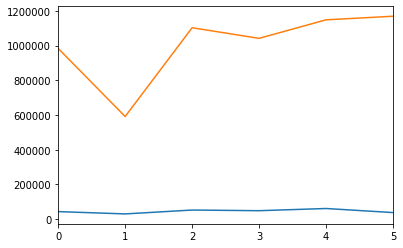

In [28]:
monthly_purchase = pd.DataFrame(df_train_purchase.groupby('PurchaseMonth')['Date_received','Date'].count()).reset_index()
monthly_purchase.columns = ['Month','PurchasesWithCoupon','TotalPurchases']
monthly_purchase['Purchase_Ratio'] = monthly_purchase['PurchasesWithCoupon']/monthly_purchase['TotalPurchases']
monthly_purchase['PurchasesWithCoupon'].plot()
monthly_purchase['TotalPurchases'].plot()
plt.show()

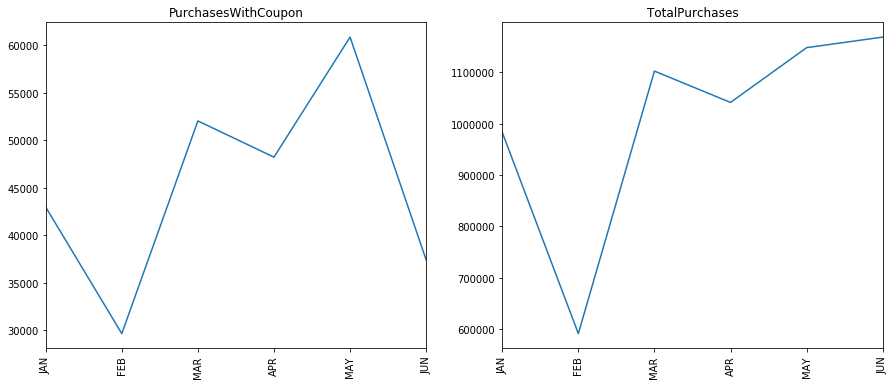

In [29]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
plt.subplot(121)
# plt.figure(figsize=(7,4))
ax1 = monthly_purchase['PurchasesWithCoupon'].plot()
ax1.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN'],rotation=90)
for p in ax1.patches:
        ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.title('PurchasesWithCoupon')

plt.subplot(122)
# plt.figure(figsize=(7,4))
ax2 =monthly_purchase['TotalPurchases'].plot()
ax2.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN'],rotation=90)
for p in ax2.patches:
        ax2.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.title('TotalPurchases')

plt.show()

In [30]:
monthly_purchase

,Month,PurchasesWithCoupon,TotalPurchases,Purchase_Ratio
0,1,42977,983371,0.043704
1,2,29674,591081,0.050203
2,3,52031,1102745,0.047183
3,4,48225,1041631,0.046298
4,5,60846,1148383,0.052984
5,6,37425,1169012,0.032014


## Date Level Features

In [31]:
date_level = pd.DataFrame(df_off_coupon.groupby(['Date_received']).size().reset_index(name='ReleasesCount'))
date_level['ImpDay'] = [1 if x>10000 else 0 for x in date_level['ReleasesCount']]
date_level.loc[:,('Weekend')]  = np.where((date_level.loc[:,('Date_received')].dt.dayofweek) < 5,0,1)
date_level.loc[:,('DayOfWeek')] = date_level.loc[:,('Date_received')].dt.dayofweek
date_level.head()

,Date_received,ReleasesCount,ImpDay,Weekend,DayOfWeek
0,2016-01-01,553,0,0,4
1,2016-01-02,541,0,1,5
2,2016-01-03,529,0,1,6
3,2016-01-04,574,0,0,0
4,2016-01-05,677,0,0,1


In [32]:
unique_coupons_train = pd.DataFrame(df_off_coupon.groupby(['Date_received'])['Coupon_id'].nunique()
                                   .reset_index(name='UniqueReleasesCount'))
unique_coupons_train.head()

,Date_received,UniqueReleasesCount
0,2016-01-01,136
1,2016-01-02,120
2,2016-01-03,129
3,2016-01-04,130
4,2016-01-05,156


In [33]:
date_level = date_level.merge(unique_coupons_train,how='left',on='Date_received')
date_level.head()

,Date_received,ReleasesCount,ImpDay,Weekend,DayOfWeek,UniqueReleasesCount
0,2016-01-01,553,0,0,4,136
1,2016-01-02,541,0,1,5,120
2,2016-01-03,529,0,1,6,129
3,2016-01-04,574,0,0,0,130
4,2016-01-05,677,0,0,1,156


In [34]:
date_level.columns

Index(['Date_received', 'ReleasesCount', 'ImpDay', 'Weekend', 'DayOfWeek',
       'UniqueReleasesCount'],
      dtype='object')

In [35]:
date_level['ReleasesCount'].describe()

count      167.000000
mean      6080.173653
std       9512.153050
min        529.000000
25%        988.500000
50%       3707.000000
75%       6184.000000
max      70319.000000
Name: ReleasesCount, dtype: float64

## Date Level Features - TEST Data

In [36]:
date_level_test = pd.DataFrame(df_test.groupby(['Date_received']).size().reset_index(name='ReleasesCount'))
date_level_test['ImpDay'] = [1 if x>10000 else 0 for x in date_level_test['ReleasesCount']]
date_level_test.loc[:,('Weekend')]  = np.where((date_level_test.loc[:,('Date_received')].dt.dayofweek) < 5,0,1)
date_level_test.loc[:,('DayOfWeek')] = date_level_test.loc[:,('Date_received')].dt.dayofweek
date_level_test.head()

,Date_received,ReleasesCount,ImpDay,Weekend,DayOfWeek
0,2016-07-01,3808,0,0,4
1,2016-07-02,3831,0,1,5
2,2016-07-03,5491,0,1,6
3,2016-07-04,5121,0,0,0
4,2016-07-05,4693,0,0,1


In [37]:
unique_coupons_test = pd.DataFrame(df_test.groupby(['Date_received'])['Coupon_id'].nunique()
                                   .reset_index(name='UniqueReleasesCount'))
unique_coupons_test.head()

,Date_received,UniqueReleasesCount
0,2016-07-01,527
1,2016-07-02,434
2,2016-07-03,477
3,2016-07-04,478
4,2016-07-05,492


In [38]:
date_level_test = date_level_test.merge(unique_coupons_test,how='left',on='Date_received')
date_level_test.head()

,Date_received,ReleasesCount,ImpDay,Weekend,DayOfWeek,UniqueReleasesCount
0,2016-07-01,3808,0,0,4,527
1,2016-07-02,3831,0,1,5,434
2,2016-07-03,5491,0,1,6,477
3,2016-07-04,5121,0,0,0,478
4,2016-07-05,4693,0,0,1,492


In [39]:
date_level_test.columns

Index(['Date_received', 'ReleasesCount', 'ImpDay', 'Weekend', 'DayOfWeek',
       'UniqueReleasesCount'],
      dtype='object')

In [40]:
date_level = date_level.append(date_level_test, sort=False)

In [41]:
date_level.to_csv('DataSets/DatasetsCreated/date_level.csv',index=False)